## Monocle3 Python

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from py_monocle import (
    learn_graph,
    order_cells,
    compute_cell_states,
    regression_analysis,
    differential_expression_genes,
)

In [3]:
ROOT_DIR = os.path.abspath("")
DATA_PATH = os.path.join(ROOT_DIR, "data", "processed_data.h5")

In [4]:
with h5py.File(DATA_PATH, "r") as f:
    umap = f["UMAP"][()]
    louvain = f["Louvain"][()]

    barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
    features = [ft.decode() for ft in f["expression_matrix/features"]]
    data = f["expression_matrix/data"][()]
    indices = f["expression_matrix/indices"][()]
    indptr = f["expression_matrix/indptr"][()]

expression_matrix = sparse.csr_matrix(
    (data, indices, indptr),
    shape=(len(barcodes), len(features))
)

#### Learn the trajectory graph

In [5]:
projected_points, mst, centroids = learn_graph(matrix=umap, clusters=louvain)

#### Pseudotime

In [6]:
pseudotime = order_cells(
    umap, centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=0,
)

#### Plot trajectory graph

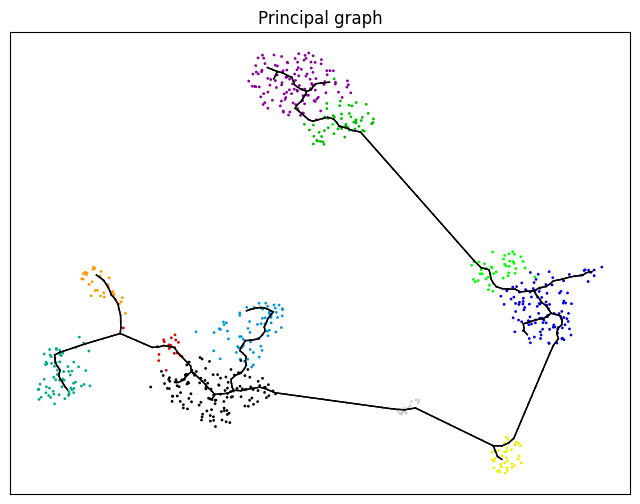

In [7]:
plt.figure(1, (8, 6))
plt.title("Principal graph")
plt.scatter(umap[:, 0], umap[:, 1], c=louvain, s=1, cmap="nipy_spectral")

edges = np.array(mst.nonzero()).T
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([])
plt.yticks([])
plt.show()

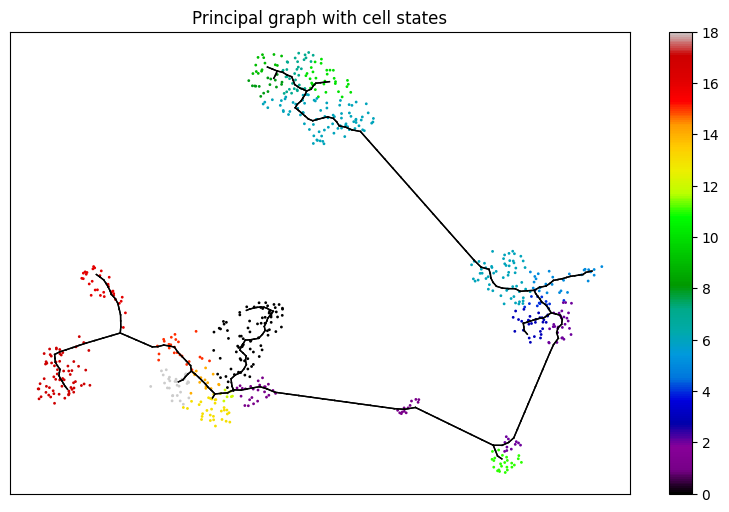

In [8]:
plt.figure(1, (10, 6))
plt.title("Principal graph with cell states")
cell_states, _ = compute_cell_states(umap, centroids, mst)
plt.scatter(umap[:, 0], umap[:, 1], c=cell_states, s=1, cmap="nipy_spectral")
plt.colorbar()
edges = np.array(mst.nonzero()).T
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([])
plt.yticks([])
plt.show()

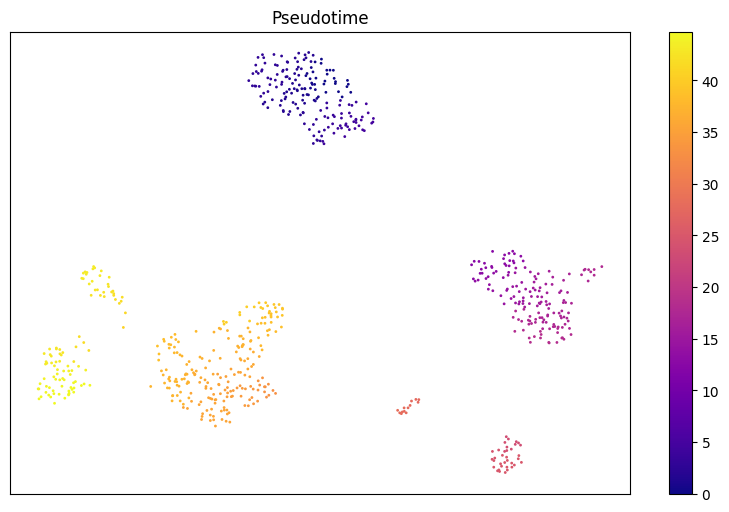

In [9]:
plt.figure(1, (10, 6))
plt.title("Pseudotime")
plt.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=1, cmap="plasma")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

#### Differential Expression Genes

In [10]:
morans_i_scores, pvalues, adjusted_pvalues = differential_expression_genes(
    expression_matrix,
    projected_cells=projected_points,
)
morani_results = pd.DataFrame(
    {
        "Moran's I score": morans_i_scores,
        "P-values": np.round(pvalues, 4),
        "Adjusted P-values": np.round(adjusted_pvalues, 4),
        "Gene Indices": np.arange(len(morans_i_scores))
    },
    index=pd.Series(features, name="Genes"),
).sort_values("Moran's I score", ascending=False)
morani_results.head(10)

,Moran's I score,P-values,Adjusted P-values,Gene Indices
Genes,,,,
FTL,0.913133,0.0,0.0,715
HLA-DRA,0.886904,0.0,0.0,236
LYZ,0.886287,0.0,0.0,487
AIF1,0.875502,0.0,0.0,232
LST1,0.871352,0.0,0.0,231
HLA-DQA1,0.864717,0.0,0.0,239
HLA-DPB1,0.854459,0.0,0.0,245
CST3,0.847963,0.0,0.0,641
CD74,0.844292,0.0,0.0,209


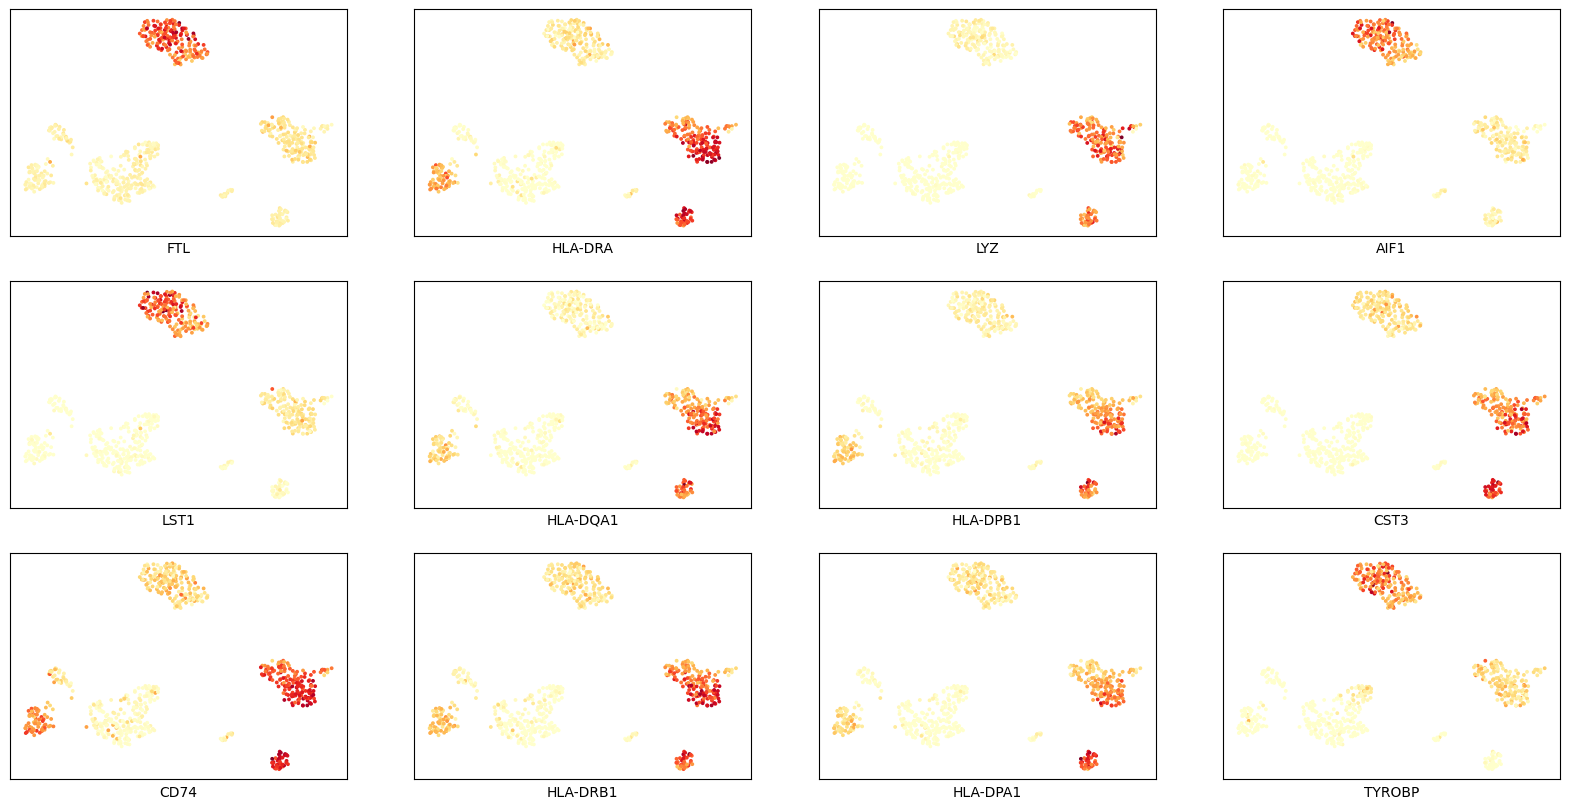

In [11]:
plt.figure(12, (20, 10))
for i, gene_idx in enumerate(morani_results["Gene Indices"].values[:12]):
    plt.subplot(3, 4, i + 1)
    plt.scatter(umap[:, 0], umap[:, 1], c=expression_matrix[:, gene_idx].toarray(), s=3, cmap="YlOrRd")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(features[gene_idx])
plt.show()

#### Regression Analysis

In [3]:
np.random.seed(52)
rand_gene_indices = np.random.permutation(len(features))[:50]
gene_names = np.array(features)[rand_gene_indices]
subset_expression_matrix = expression_matrix.tocsc()[:, rand_gene_indices]

with h5py.File(DATA_PATH, "r") as f:
  R_pseudotime = f["pseudotime"][()]

In [11]:
pvals_matrix = regression_analysis(subset_expression_matrix, pseudotime, cell_states)
pvals_matrix_R = regression_analysis(subset_expression_matrix, R_pseudotime, cell_states)

In [ ]:
n_states = len(np.unique(cell_states))

fig = plt.figure(2, (10, 6))
fig.suptitle("Regression analysis", fontsize=16)
ax = plt.subplot(2, 1, 1)
s = ax.imshow(pvals_matrix)
ax.set_yticks(np.arange(n_states))
ax.set_yticklabels([f"state {i}" for i in range(n_states)])
ax.set_xticks([])
ax.set_title("p-values each state - py-monocle")
fig.colorbar(s)
ax = plt.subplot(2, 1, 2)
s = ax.imshow(pvals_matrix_R)
ax.set_yticks(np.arange(n_states))
ax.set_yticklabels([f"state {i}" for i in range(n_states)])
ax.set_xticks(np.arange(len(gene_names)))
ax.set_xticklabels(gene_names, rotation='vertical')
ax.set_title("p-values each state - monocle3-R")
fig.colorbar(s)
plt.show()